In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.estimators import losses


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [6]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [7]:
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

label_cols = label_metadata.gz2_partial_label_cols
questions = label_metadata.gz2_partial_questions

# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'gz2'
schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1)}


In [8]:
concentration_cols = [col + '_concentration' for col in label_cols]
concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

# for it in it_list:
#     for col in concentration_cols:
#         it[col] = it[col].apply(lambda x: np.array(json.loads(x)))

In [10]:
m = 0
n_models = 3  # important

# optimise spiral, predict 4q
# active_locs = [f'temp/gz2_1q_conc_active_it2_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_conc_baseline_it2_m{n}.csv' for n in range(n_models)]


# optimise smooth/feat, predict 1q

# active_locs = [f'temp/gz2_1q_1active_it0_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it0_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it1_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it1_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it2_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it2_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it2_m{n}_log.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it2_m{n}_log.csv' for n in range(n_models)]

baseline_locs = [f'temp/gz2_1q_1baseline_it1_m{n}_log.csv' for n in range(n_models)]
active_locs = [f'temp/gz2_1q_1active_best_it1_m{n}.csv' for n in range(n_models)]

active_dfs = [pd.read_csv(loc) for loc in active_locs]
baseline_dfs = [pd.read_csv(loc) for loc in baseline_locs]


In [12]:
active_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in active_dfs]
baseline_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in baseline_dfs]

In [13]:
answer_cols = [a.text for a in schema.answers]
labels = active_dfs[0][answer_cols].values  # same for all

In [14]:
labels.shape

(15000, 2)

In [15]:
active_concentrations[0].shape

(15000, 2, 2)

In [16]:
active_concentrations_combined = np.concatenate(active_concentrations, axis=-1)
active_concentrations_combined.shape

(15000, 2, 6)

In [17]:
for model_n in range(n_models):
    single_loss = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations[model_n], schema.question_index_groups)
    print(list(zip(questions, single_loss.mean(axis=0))))

[('smooth-or-featured', 2.4551694)]
[('smooth-or-featured', 2.527824)]
[('smooth-or-featured', 2.5406475)]


In [18]:

active_losses = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations_combined, schema.question_index_groups)
list(zip(questions, active_losses.mean(axis=0)))

[('smooth-or-featured', 2.4800339)]

In [19]:
baseline_concentrations_combined = np.concatenate(baseline_concentrations, axis=-1)

In [20]:
for model_n in range(n_models):
    baseline_single_loss = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentrations[model_n], schema.question_index_groups)
    print(list(zip(questions, baseline_single_loss.mean(axis=0))))

[('smooth-or-featured', 2.453548)]
[('smooth-or-featured', 2.514228)]
[('smooth-or-featured', 2.5418787)]


In [21]:

baseline_losses = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentrations_combined, schema.question_index_groups)
list(zip(questions, baseline_losses.mean(axis=0)))

[('smooth-or-featured', 2.4775681)]

In [22]:
assert len(active_losses) == len(baseline_losses)

In [23]:
active_like = np.exp(-active_losses)  # inverse of neg log likelihood = 
baseline_like = np.exp(-baseline_losses)

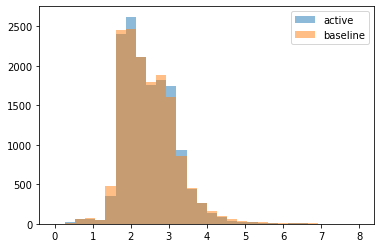

In [24]:
plt.hist(active_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='active')
plt.hist(baseline_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='baseline')
plt.legend()

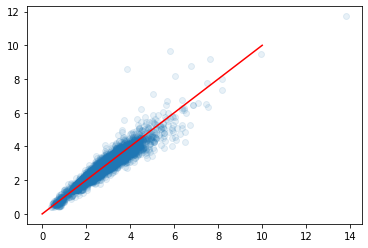

In [25]:
plt.scatter(baseline_losses[:, 0], active_losses[:, 0], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

In [26]:
baseline_losses.shape

(15000, 1)

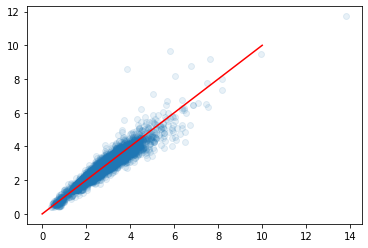

In [27]:
question_n = 0
plt.scatter(baseline_losses[:, question_n], active_losses[:, question_n], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

(0.0, 0.5)

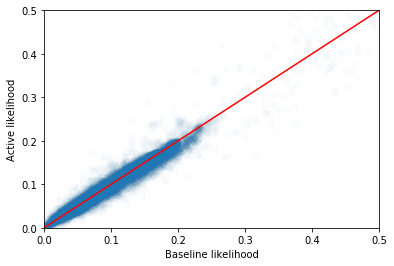

In [28]:
question_n = 0
plt.scatter(baseline_like[:, question_n], active_like[:, question_n], alpha=.02)
plt.xlabel('Baseline likelihood')
plt.ylabel('Active likelihood')
plt.plot([0., 1], [0., 1.], color='r')
plt.xlim(0., .5)
plt.ylim((0., .5))

(0.0, 0.3)

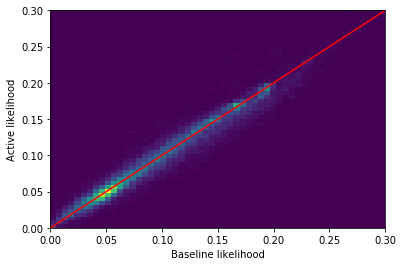

In [29]:
question_n = 0
plt.hist2d(baseline_like[:, question_n], active_like[:, question_n], bins=(120, 120))
plt.xlabel('Baseline likelihood')
plt.ylabel('Active likelihood')
plt.plot([0., 1], [0., 1.], color='r')
plt.xlim(0., .3)
plt.ylim((0., .3))

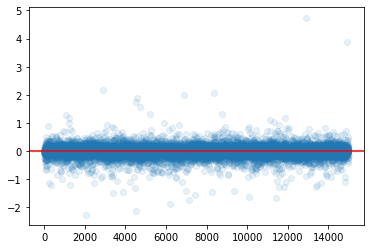

In [30]:
question_n = 0
plt.scatter(np.arange(len(baseline_losses)), active_losses[:, question_n] - baseline_losses[:, question_n], alpha=.1)
plt.axhline(0., color='r')

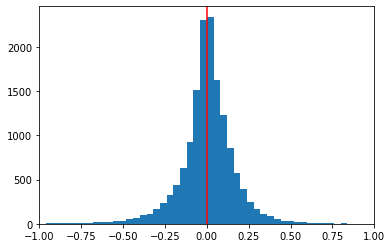

In [31]:
question_n = 0
_ = plt.hist(active_losses[:, question_n] - baseline_losses[:, question_n], range=(-1, 1), bins=50)
plt.xlim(-1, 1)
plt.axvline(0., color='r')

In [32]:
for question_n in range(1):
    print((active_losses[:, question_n] - baseline_losses[:, question_n]).mean())

0.0024658428


In [33]:
question_n = 0
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0024658428
2 0.0031592315
5 0.004284855
10 0.005986318
20 0.008164917
30 0.0077225426
40 0.006998348


In [34]:

for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0024658428
2 0.0031592315
5 0.004284855
10 0.005986318
20 0.008164917
30 0.0077225426
40 0.006998348


In [35]:
question_n = 0

In [36]:
results = []
mean_loss = (active_losses[:, question_n] + baseline_losses[:, question_n]) / 2
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
    selection = (mean_loss < max_val) & (mean_loss >= min_val)
    
    valid_delta = delta_loss[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))


0 10
0 10 1500 0.021985445 23.0
10 20
10 20 1500 0.025077749 20.0
20 30
20 30 1500 0.012153567 22.0
30 40
30 40 1500 0.0014728802 29.5
40 50
40 50 1500 0.0063807876 20.0
50 60
50 60 1500 0.002270775 26.0
60 70
60 70 1500 0.01316482 22.5
70 80
70 80 1500 0.016400922 19.5
80 90
80 90 1500 0.0030652059 19.0
90 100
90 100 1499 -0.07595566 29.5


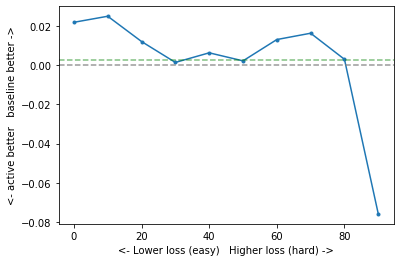

In [37]:
x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower loss (easy)   Higher loss (hard) ->')
plt.ylabel('<- active better   baseline better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0 5
0 5 750 0.0016335244 21.0
5 10
5 10 750 0.0015584818 29.5
10 15
10 15 750 5.4453412e-05 24.0
15 20
15 20 750 -0.00047530374 19.0
20 25
20 25 750 -0.00088422984 23.0
25 30
25 30 750 -0.0006169342 19.5
30 35
30 35 750 -0.0011883294 19.0
35 40
35 40 750 -0.0005766119 22.5
40 45
40 45 750 -0.000106309264 26.0
45 50
45 50 750 -0.00043365787 18.5
50 55
50 55 750 -0.0005779145 20.0
55 60
55 60 750 -0.0006702223 20.5
60 65
60 65 750 -1.1197189e-05 29.5
65 70
65 70 750 -0.00020608166 22.5
70 75
70 75 750 -0.0015145607 23.0
75 80
75 80 750 -0.0020251826 22.0
80 85
80 85 750 -0.0036284195 20.0
85 90
85 90 750 -0.0049021654 21.5
90 95
90 95 750 -0.005463262 23.0
95 100
95 100 749 -0.0015478204 27.0


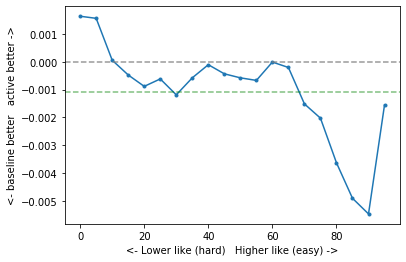

In [38]:
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
bin_width = 5
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (hard)   Higher like (easy) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0.0 2.0
0.0652
2.0 3.0
0.08246666666666666
3.0 4.0
0.09926666666666667
4.0 5.0
0.0916
5.0 7.0
0.14646666666666666
7.0 9.0
0.09253333333333333
9.0 14.0
0.11826666666666667
14.0 21.200000000000728
0.1042
21.200000000000728 33.0
0.0938
33.0 60.0
0.10613333333333333


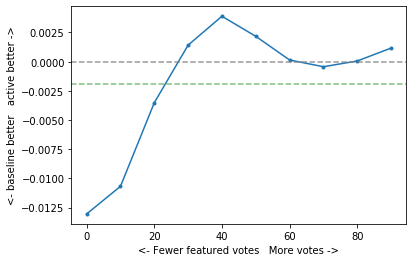

In [39]:

results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values  # FEATURED votes

bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
    selection = (votes < max_val) & (votes >= min_val)
    print(min_val, max_val)
    print(selection.mean())
    
    valid_delta = delta_like[selection]
#     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Fewer featured votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

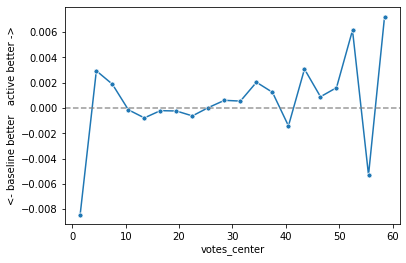

In [40]:
question_n = 0
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values

votes_binned = pd.cut(votes, bins=20)
df = pd.DataFrame(data={'votes_binned': votes_binned, 'delta_like': delta_like})
df['votes_center'] = df['votes_binned'].apply(lambda x: x.left + (x.right - x.left)/2)

grouped = df.groupby('votes_center').agg({'delta_like': 'mean'}).reset_index()

sns.lineplot(data=grouped, x='votes_center', y='delta_like', marker='.', markersize=10)

# bin_width = 10
# for min_pc in np.arange(0, 100, bin_width):
#     max_pc = min_pc + bin_width
#     min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
#     selection = (votes < max_val) & (votes >= min_val)
#     print(min_val, max_val)
#     print(selection.mean())
    
#     valid_delta = delta_like[selection]
# #     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
#     results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

# x = [r[0] for r in results]
# y = [r[2] for r in results]
# plt.plot(x, y, marker='.')
# plt.xlabel('<- Fewer votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
# plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

(array([3704., 4333., 1874., 1025.,  737.,  620.,  498.,  496.,  451.,
         525.,  396.,  206.,   92.,   32.,   11.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40., 44., 48.,
        52., 56., 60.]),
 <a list of 15 Patch objects>)

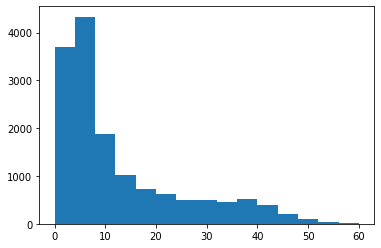

In [41]:
plt.hist(votes, bins=15)

In [42]:
assert False

AssertionError: 

In [ ]:
# def pretend_fewer_votes_multiq(labels, question_index_groups):
    
#     q_losses = []
#     for q_n in range(len(question_index_groups)):
#         q_indices = question_index_groups[q_n]
#         q_start = q_indices[0]
#         q_end = q_indices[1]
#         q_loss = pretend_fewer_votes(labels[:, q_start:q_end+1])
#         q_losses.append(q_loss)
    
#     total_loss = np.stack(q_losses, axis=1)
#     return total_loss

def pretend_fewer_votes(votes, new_total=10):
    # votes = (batch, answer) for one q

    n_votes = votes.shape[1]
    new_vote_indices = [np.random.choice(np.arange(n_votes), p=v/v.sum(), size=new_total) for v in votes]
    new_votes = []
    for n in new_vote_indices:
        these_votes = np.zeros(n_votes)
        for i in n:
            these_votes[i] += 1
        new_votes.append(these_votes)
    return np.array(new_votes)

In [ ]:
schema.question_index_groups

In [ ]:
question_n = 0
question_indices = [2, 4]
question_slice = slice(*question_indices)
batch_slice = labels[:, question_slice].sum(axis=1) >= 10
fewer_votes = pretend_fewer_votes(labels[batch_slice, question_slice])

In [ ]:
reduced_labels = labels.copy()
reduced_labels[batch_slice, question_slice] = fewer_votes

In [ ]:
reduced_labels[batch_slice, question_slice]

In [ ]:
active_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, active_concentrations_combined, schema.question_index_groups)
baseline_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, baseline_concentrations_combined, schema.question_index_groups)

In [ ]:

np.mean(active_losses[:, question_n]), np.mean(baseline_losses[:, question_n])

In [ ]:

np.mean(active_losses_reduced[:, question_n]), np.mean(baseline_losses_reduced[:, question_n])

In [ ]:
active_like_reduced = np.exp(-active_losses_reduced)
baseline_like_reduced = np.exp(-baseline_losses_reduced)

In [ ]:

np.mean(active_like_reduced[batch_slice, question_n]), np.mean(baseline_like_reduced[batch_slice, question_n])

In [ ]:
results = []
mean_like = (active_like_reduced[batch_slice, question_n] + baseline_like_reduced[batch_slice, question_n]) / 2
delta_like = active_like_reduced[batch_slice, question_n] - baseline_like_reduced[batch_slice, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    results.append((min_pc, max_pc, valid_delta.mean()))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (worse)   Higher like (better) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
plt.scatter(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, alpha=.02, s=10)
plt.xlim(0, 50)
plt.ylim(0, 4)
plt.xlabel('Featured/spiral total votes')
plt.ylabel('Spiral loss')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
g = sns.jointplot(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, kind='hex')
g.ax_marg_x.set_xlim(0, 50)
g.ax_marg_y.set_ylim(0, 4)

In [ ]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            ax = plt.subplot(gs1[row_n, col_n])
            if os.path.isfile(galaxy['local_png_loc']):
                image = Image.open(galaxy['local_png_loc'])
                ax.imshow(image)
    #             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
    #             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
    #             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            else:
                print('Failed to find ', galaxy['local_png_loc'])
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [ ]:
# active_df_with_pics = pd.merge(active_dfs[0], catalog['', how='left', on='id_str')

In [ ]:
# active_df_with_pics.columns.values

In [ ]:

min_pc = 0
max_pc = 10
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 20
max_pc = 30
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 80
max_pc = 90
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 90
max_pc = 100
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:
question_n

In [ ]:
limits = (0., 8.)
plt.hist(active_losses[:, question_n], bins=30, alpha=.5, range=limits, label='active')
plt.hist(baseline_losses[:, question_n], bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_losses[:, question_n].mean(), baseline_losses[:, question_n].mean()

In [ ]:
limits = (0., 8.)
plt.hist(np.exp(active_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='active')
plt.hist(np.exp(baseline_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_like

In [ ]:
total_votes = labels[:, :3].sum(axis=1)
retired_selection = total_votes > 36
retired_selection.mean()

In [ ]:
plt.hist(total_votes, bins=30)

In [ ]:
schema.questions

In [ ]:
question_n = 2
bins = 30
plt.hist(active_like[:, question_n], bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n], bins=bins, alpha=.5, label='baseline')
plt.legend()

In [ ]:

active_like.mean(axis=0), baseline_like.mean(axis=0)

In [ ]:

active_like.mean(axis=0) - baseline_like.mean(axis=0)

In [ ]:
active_like[:, question_n].mean(), baseline_like[:, question_n].mean()

In [ ]:
np.product(active_like[:, question_n]), np.product(baseline_like[:, question_n])

In [ ]:
low, high = 10 ** 3, .9
bins = np.logspace(np.log10(low),np.log10(high), 50)
plt.hist(active_like[:, question_n]), bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n]), bins=bins, alpha=.5, label='baseline')
plt.gca().set_xscale("log")
plt.legend()

In [ ]:
np.exp(active_losses[:, question_n]).mean(), np.exp(baseline_losses[:, question_n]).mean()